In [2]:
# %%writefile Ind_xxxxx.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat


In [3]:
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

tail = False
if tail:
    file = 'all_tail_qfq'
else:
    file = 'all_train_qfq'
    
df_all = load_cache(file,cache_type=CACHE_TYPE.STOCK).sort_index()
smpl.optimize_data_type(df_all)

data_ = df_all

year1 = '2017'
year2 = '2017'
data_ = df_all.loc[year1+'-01-03':year2+'-12-31']
codes = data_.index.get_level_values(1).unique()
dates = data_.index.get_level_values(0).unique()

In [4]:
data_

open       high        low      close     volume  \
date       code                                                            
2017-01-03 000001   8.178117   8.240956   8.160162   8.223001   459840.0   
           000002  15.787499  16.041021  15.787499  15.925784   217016.0   
           000004  44.810001  44.840000  43.610001  44.450001     7154.0   
           000006   7.760734   7.989471   7.736226   7.899610   251674.0   
           000007  17.400000  17.533333  17.173334  17.400000    17278.0   
...                      ...        ...        ...        ...        ...   
2017-12-29 603991  27.634617  27.891407  27.446962  27.812395     5911.0   
           603993   6.384641   6.439681   6.274561   6.311255  1393446.0   
           603997  10.178513  10.232462   9.890780  10.133554    28166.0   
           603998  10.290934  10.345575  10.063258  10.190756    18892.0   
           603999   7.390282   7.438396   7.313300   7.399905    20792.0   

                        amount       adj        shares       lshares  \
date       code                                                        
2017-01-03 000001  420595168.0  0.897708  1.430868e+06  1.219265e+06   
           000002  449757472.0  0.768248  1.103915e+06  9.709068e+05   
           000004   31737710.0  1.000000  8.397668e+03  8.296368e+03   
           000006  243074080.0  0.816919  1.349995e+05  1.344884e+05   
           000007   44872752.0  0.666667  2.309654e+04  2.059654e+04   
...                        ...       ...           ...           ...   
2017-12-29 603991   16585302.0  0.987656  7.453500e+03  1.870000e+03   
           603993  961132096.0  0.917333  2.159924e+06  1.295373e+06   
           603997   31425960.0  0.899162  6.300000e+04  1.710000e+04   
           603998   21112820.0  0.910702  4.309365e+04  4.251967e+04   
           603999   15909522.0  0.962276  5.760000e+04  2.304000e+04   

                   market_value  liquidity_market_value industry  
date       code                                                   
2017-01-03 000001  1.176603e+11            1.002602e+11    股份制银行  
           000002  1.758072e+11            1.546245e+11     住宅开发  
           000004  3.732763e+09            3.687736e+09     基础软件  
           000006  1.066443e+10            1.062406e+10     住宅开发  
           000007  4.018797e+09            3.583797e+09   商业物业经营  
...                         ...                     ...      ...  
2017-12-29 603991  2.072997e+09            5.200918e+08   其他塑料制品  
           603993  1.363183e+11            8.175429e+10       钨钼  
           603997  6.384139e+09            1.732838e+09  车身附件及饰件  
           603998  4.391569e+09            4.333076e+09       中药  
           603999  4.262345e+09            1.704938e+09     大众出版  

[563256 rows x 12 columns]

In [44]:
# 个股情绪
turnover = data_['volume'] / (data_['lshares'] *100) 
# volume
# 880876 户数增加
# 880877 户数减少
# 880780 融资增加
# 880990 TDX 金融
# 880779 高融资盘
# 880792 基金增仓
# 880793 基金减仓
# 880751 昨日跌停
# 880752 昨曾跌停
# 880008 全Ａ等权
# 880018 主板等权

# 000159 沪股通
# 880005 涨跌家数 收=涨停数，开=跌停数
# 880006 停板家数 收=涨停数，开=跌停数，高=最大涨停数

In [36]:
bench = smpl.get_benchmark(name='沪深300', start=dates.min(), end=dates.max()).data

In [45]:
a = smpl.get_index_data(['880990'], start=dates.min(), end=dates.max(), gap=None).data


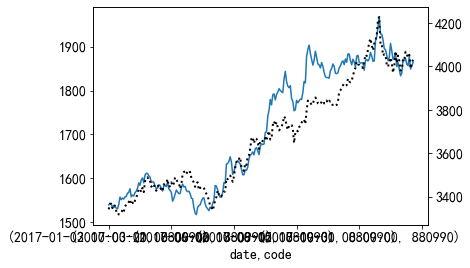

In [46]:
a['close'].groupby(level=1).apply(lambda x:x.plot())
ax3 = plt.gca().twinx()
ax3.plot(range(bench.shape[0]),bench['close'].values,linestyle=":", linewidth=2,color="black",label='bm')

In [ ]:
# 市场情绪